# Home work 3: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- HW3_Modules.ipynb
- HW3_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import pickle as pkl
import copy
import matplotlib.pyplot as plt
from IPython import display
from collections import Counter
from sklearn.preprocessing import OneHotEncoder
import os
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

<a id='toc'></a>
# Table of contents
* [0. Code](#code)
    * [0.1 Module and Sequential](#code1)
    * [0.2 Linear and SoftMax](#code2)
    * [0.3 BatchMeanSubtraction and Dropout](#code3)
    * [0.4 Activations](#code4)
    * [0.5 Criterions](#code5)
* [1. Framework](#framework)
    * [1.1 Helper functions](#funcs)
        * [1.1.1 SGD optimizer](#sgd)
        * [1.1.2 Batches generator](#bgen)
        * [1.2.3 Class based model trainer (more convenient than function based)](#class-based)
* [2. Toy example](#toy)
    * [2.1 Network 1](#toy1)
    * [2.2 Network 2](#toy2)
* [3. Digit classification](#digits)
    * [3.1 Test run](#test_run)
    * [3.2 Comparison](#comp)
        * [3.2.1 Generator of test network](#test_net_gen)
        * [3.2.2 Comparison](#comparison)
    * [3.3 Final run](#final_run)

<a id='code'></a>
# 0.1 Code<sup>[toc](#toc)</sup>
For debuggin purposes the model code was imported here. The same code resides in HW3_Modules.ipynb

<a id='code1'></a>
### 0.1 Module and Sequential<sup>[toc](#toc)</sup>

In [26]:
class Module(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        self.trainings = True

    def forward(self, input):
        return self.updateOutput(input)

    def updateOutput(self, input):
        assert False, "Base version must not be called"
        pass
    
    def backward(self, input, gradOutput):
        self.updateGradInput(input, gradOutput)
        self.accGradParameters(input, gradOutput)
        return self.gradInput

    def updateGradInput(self, input, gradOutput):
        pass   
    
    def accGradParameters(self, input, gradOutput):
        pass
    
    def zeroGradParameters(self): 
        pass
        
    def getParameters(self):
        return []
        
    def getGradParameters(self):
        return []
    
    def training(self):
        self.trainings = True
    
    def evaluate(self):
        self.trainings = False
    
    def __repr__(self):
        return "Module"
    
    
class Sequential(Module):
    def __init__ (self):
        super(Sequential, self).__init__()
        self.modules = []
   
    def add(self, module):
        self.modules.append(module)

    def updateOutput(self, input):
        self.outputs = []
        for i in range(len(self.modules)):
            input = self.modules[i].forward(input)
            self.outputs.append(input)
        self.output = self.outputs[-1]
        return self.output

    def backward(self, input, gradOutput):
        for i in reversed(range(1, len(self.modules))):
            gradOutput = self.modules[i].backward(self.outputs[i - 1], gradOutput)
        self.gradInput = self.modules[0].backward(input, gradOutput)
        return self.gradInput
      
    def zeroGradParameters(self): 
        for module in self.modules:
            module.zeroGradParameters()
    
    def getParameters(self):
        return [x.getParameters() for x in self.modules]
    
    def getGradParameters(self):
        return [x.getGradParameters() for x in self.modules]
    
    def training(self):
        self.trainings = True
        for i in range(len(self.modules)):
            self.modules[i].training()
    
    def evaluate(self):
        self.trainings = False
        for i in range(len(self.modules)):
            self.modules[i].evaluate()
        
    def __repr__(self):
        string = "".join([str(x) + '\n' for x in self.modules])
        return string
    
    def __getitem__(self,x):
        return self.modules.__getitem__(x)

<a id='code2'></a>
### 0.2 Linear and SoftMax<sup>[toc](#toc)</sup>

In [43]:
class Linear(Module):
    def __init__(self, n_in, n_out):
        super(Linear, self).__init__()
        self.n_in = n_in
        self.n_out = n_out
        stdv = 1 / np.sqrt(n_in)
        self.W = np.random.uniform(-stdv, stdv, size=(n_in, n_out))
        self.b = np.random.uniform(-stdv, stdv, size=n_out)
        self.gradW = np.zeros_like(self.W)
        self.gradb = np.zeros_like(self.b)
        
    def updateOutput(self, input):
        assert len(input.shape) == 2
        assert input.shape[1] == self.n_in
        self.output = np.dot(input, self.W) + self.b[np.newaxis, :]
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.dot(gradOutput, self.W.T)
        assert self.gradInput.shape == input.shape
        return self.gradInput
    
    def accGradParameters(self, input, gradOutput):
        self.gradW = np.dot(input.T, gradOutput) / input.shape[0]
        self.gradb = np.sum(gradOutput, axis=0) / input.shape[0]
    
    def zeroGradParameters(self):
        self.gradW.fill(0)
        self.gradb.fill(0)
        
    def getParameters(self):
        return [self.W, self.b]
    
    def getGradParameters(self):
        return [self.gradW, self.gradb]
    
    def __repr__(self):
        s = self.W.shape
        q = 'Linear %d -> %d' %(s[1],s[0])
        return "Linear"
    
    
class SoftMax(Module):
    def __init__(self):
         super(SoftMax, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.subtract(input, input.max(axis=1, keepdims=True))
        a = np.exp(self.output)
        self.output = a / np.sum(a, axis=1)[:, np.newaxis]
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        G = np.multiply(gradOutput, self.output)
        coeffs = G.sum(axis=1)[:, np.newaxis]
        self.gradInput = G - np.multiply(self.output, coeffs)
        return self.gradInput
    
    def __repr__(self):
        return "SoftMax"

<a id='code3'></a>
### 0.3 BatchMeanSubtraction and Dropout<sup>[toc](#toc)</sup>

In [45]:
class BatchMeanSubtraction(Module):
    def __init__(self, alpha=0):
        super(BatchMeanSubtraction, self).__init__()
        self.train_alpha = alpha
        self.alpha = alpha
        self.old_mean = None
        
    def updateOutput(self, input):
        if self.old_mean is None:
            self.old_mean = np.mean(input, axis=0)
        else:
            self.old_mean = self.alpha * self.old_mean + (1 - self.alpha) * np.mean(input, axis=0)
        self.output = input - self.old_mean[np.newaxis, :]
        return self.output 
    
    def training(self):
        self.trainings = True
        self.alpha = self.train_alpha
    
    def evalute(self, input):
        self.trainings = False
        self.alpha = 1.0
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = (1 - self.alpha / input.shape[0]) * np.array(gradOutput)
        return self.gradInput
    
    def __repr__(self):
        return "BatchMeanNormalization"
    
class Dropout(Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p
        self.mask = None
        
    def updateOutput(self, input):
        if self.trainings:
            self.mask = np.random.choice(2, input.shape, p=[self.p, 1 - self.p])
        else:
            self.mask = np.full(input.shape, 1 - self.p)
        self.output = np.multiply(input, self.mask)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(self.mask, gradOutput)
        return self.gradInput
        
    def __repr__(self):
        return "Dropout"

<a id='code4'></a>
### 0.4 Activations<sup>[toc](#toc)</sup>

In [46]:
class Tanh(Module):
    def __init__(self):
         super(Tanh, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.tanh(input)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply((1 - self.output ** 2), gradOutput)
        return self.gradInput
    
    def __repr__(self):
        return "Tanh"

    
class ReLU(Module):
    def __init__(self):
         super(ReLU, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.maximum(input, 0)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput, input > 0)
        return self.gradInput
    
    def __repr__(self):
        return "ReLU"

    
class LeakyReLU(Module):
    def __init__(self, slope=0.03):
        super(LeakyReLU, self).__init__()
        self.slope = slope
        
    def updateOutput(self, input):
        self.output = np.array(input)
        self.output[self.output < 0] *= self.slope
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.array(gradOutput)
        self.gradInput[input < 0] *= self.slope
        return self.gradInput
    
    def __repr__(self):
        return "LeakyReLU"
 

class ELU(Module):
    def __init__(self, alpha=1.0):
        super(ELU, self).__init__()
        self.alpha = alpha
        
    def updateOutput(self, input):
        self.output = np.array(input)
        self.mask = self.output < 0
        self.output[self.mask] = self.alpha * (np.exp(self.output[self.mask]) - 1)
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.array(gradOutput)
        self.gradInput[self.mask] *= self.alpha * np.exp(input[self.mask])
        return self.gradInput
    
    def __repr__(self):
        return "ELU"
    
    
class SoftPlus(Module):
    def __init__(self):
        super(SoftPlus, self).__init__()
    
    def updateOutput(self, input):
        self.output = np.array(input)
        self.output[input < 30] = np.log(1 + np.exp(input[input < 30]))
        return self.output
    
    def updateGradInput(self, input, gradOutput):
        self.gradInput = np.multiply(gradOutput, 1.0 / (1 + np.exp(-input)))
        return self.gradInput
    
    def __repr__(self):
        return "SoftPlus"

<a id='code5'></a>
### 0.5 Criterions<sup>[toc](#toc)</sup>

In [30]:
class Criterion(object):
    def __init__ (self):
        self.output = None
        self.gradInput = None
        
    def forward(self, input, target):
        return self.updateOutput(input, target)

    def backward(self, input, target):
        return self.updateGradInput(input, target)
    
    def updateOutput(self, input, target):
        return self.output

    def updateGradInput(self, input, target):
        return self.gradInput   

    def __repr__(self):
        return "Criterion"
    
class MSECriterion(Criterion):
    def __init__(self):
        super(MSECriterion, self).__init__()
        
    def updateOutput(self, input, target):   
        self.output = np.sum(np.power(input - target, 2)) / input.shape[0]
        return self.output 
 
    def updateGradInput(self, input, target):
        self.gradInput = 2 * (input - target)
        return self.gradInput

    def __repr__(self):
        return "MSECriterion"
    
class ClassNLLCriterion(Criterion):
    def __init__(self):
        a = super(ClassNLLCriterion, self)
        super(ClassNLLCriterion, self).__init__()
        
    def updateOutput(self, input, target): 
        input_clamp = np.maximum(1e-15, np.minimum(input, 1 - 1e-15))
        self.output = np.sum(np.multiply(target, -np.log(input_clamp))) / input.shape[0]
        return self.output

    def updateGradInput(self, input, target):
        input_clamp = np.maximum(1e-15, np.minimum(input, 1 - 1e-15))
        self.gradInput = -np.divide(target, input_clamp)
        return self.gradInput
    
    def __repr__(self):
        return "ClassNLLCriterion"

<a id='framework'></a>
# 1. Framework<sup>[toc](#toc)</sup>

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [3]:
#%run HW3_Modules.ipynb

<a id='funcs'></a>
## 1.1 Helper functions<sup>[toc](#toc)</sup>

<a id='sgd'></a>
### 1.1.1 SGD optimizer<sup>[toc](#toc)</sup>

In [31]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x, dx): 
        for cur_x, cur_dx in zip(cur_layer_x, cur_layer_dx):
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out=cur_old_grad)
            cur_x -= cur_old_grad
            i += 1

<a id='bgen'></a>
### 1.1.2 Batches generator<sup>[toc](#toc)</sup>

In [32]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        batch_idx = indices[start:end]
        yield X[batch_idx], Y[batch_idx]

<a id='class-based'></a>
### 1.2.3 Class based model trainer (more convenient than function based)<sup>[toc](#toc)</sup>

In [33]:
class SgdOptimizer(object):
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.state = {}

    def __call__(self, params, grad_params):
        self.state.setdefault('old_grad', {})
        n_params_set = 0
        for n_layer, (layer_params, layer_grad_params) in enumerate(zip(params, grad_params)): 
            for cur_params, cur_grad_params in zip(layer_params, layer_grad_params):
                cur_old_grad = self.state['old_grad'].setdefault(n_params_set, np.zeros_like(cur_params))
                np.add(self.momentum * cur_old_grad, self.lr * cur_grad_params, out=cur_old_grad)
                cur_params -= cur_old_grad
                n_params_set += 1
        
class ModelTrainer(object):
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss_history = []
        
    def train(self, X, Y, nb_epoch=10, batch_size=100, verbose=1):
        for epoch in range(nb_epoch):
            loss_values = []
            for X_batch, Y_batch in self.get_batch_generator_(X, Y, batch_size):
                self.model.zeroGradParameters()

                # Forward
                predictions = self.model.forward(X_batch)
                loss = self.criterion.forward(predictions, Y_batch)
                loss_values.append(loss)
                
                # Backward
                dp = self.criterion.backward(predictions, Y_batch)
                self.model.backward(X_batch, dp)

                # Update weights
                self.optimizer(self.model.getParameters(), self.model.getGradParameters()) 
       
            mean_loss = np.mean(loss_values)
            if verbose:
                print('epoch = {}, loss = {}'.format(epoch, mean_loss))     
            self.loss_history.append(mean_loss)  
        return self.loss_history
 
    def predict_proba(self, X, batch_size=100):
        Ys = []
        self.model.evaluate()
        for X_batch, _ in self.get_batch_generator_(X, np.arange(len(X)), batch_size, shuffle=False):
            Y_batch = self.model.forward(X_batch)
            Ys.append(Y_batch)
        self.model.training()
        Y = np.concatenate(Ys, axis=0)
        return Y
        
    def predict(self, X, batch_size=100):
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return y
        
    def get_batch_generator_(self, X, Y, batch_size, shuffle=True):
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        if shuffle:
            np.random.shuffle(indices)
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_idx = indices[start:end]
            yield X[batch_idx], Y[batch_idx]

Linear
SoftMax

epoch = 0, loss = 0.5184048063838519
epoch = 1, loss = 0.3472760327819386
epoch = 2, loss = 0.3222660854765577
epoch = 3, loss = 0.30897441092505645
epoch = 4, loss = 0.300354621066859
epoch = 5, loss = 0.2941245631935666
epoch = 6, loss = 0.2894276070870002
epoch = 7, loss = 0.28520501516797103
epoch = 8, loss = 0.28247889229385675
epoch = 9, loss = 0.2800279076216669
epoch = 10, loss = 0.27735586246339944
epoch = 11, loss = 0.27561098984990173
epoch = 12, loss = 0.2736102298486521
epoch = 13, loss = 0.27196609599657207
epoch = 14, loss = 0.27046120261971723
epoch = 15, loss = 0.26937225878179066
epoch = 16, loss = 0.2682265879900696
epoch = 17, loss = 0.26707148895112653
epoch = 18, loss = 0.26592426050661205
epoch = 19, loss = 0.2648229473455473
epoch = 20, loss = 0.2642105885478627
epoch = 21, loss = 0.26339924205902243
epoch = 22, loss = 0.26274398064912835
epoch = 23, loss = 0.2619066258989408
epoch = 24, loss = 0.26109677720863833
epoch = 25, loss = 0.26037481167

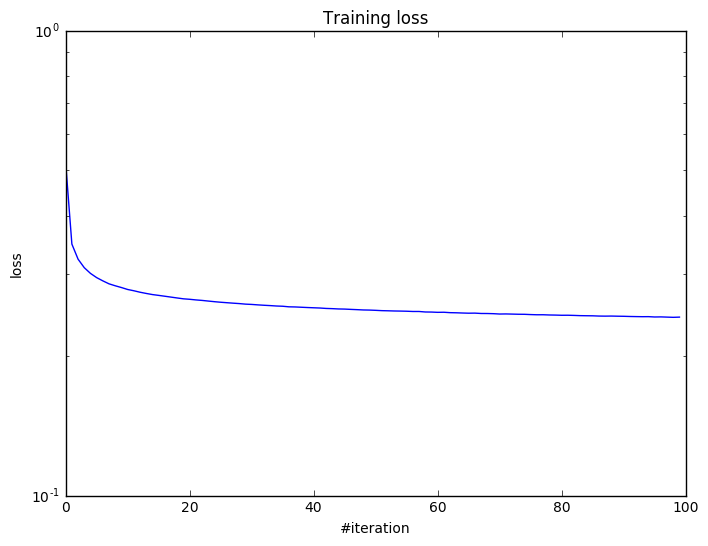